In [1]:
import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import clip
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import re
from clip.simple_tokenizer import SimpleTokenizer
import faiss
import matplotlib.pyplot as plt
#from triplet_loss import TripletLoss

%matplotlib inline


/scratch/1006532/ipykernel_2805445/3931390099.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#config
n_epochs = 20
testsize=0.1
# Step 1: Define a tensor and apply transformations first
temp = torch.tensor(0.07)

batch_size=128
model_save_dr="/home/hice1/mmoradi6/scratch/RCLIP/models/"
prob=0 #contamination level

In [3]:
#label csv
from sklearn.model_selection import train_test_split
df_data = pd.read_csv('/home/hice1/mmoradi6/scratch/RCLIP/data/train.csv', index_col='id')
df_labels=pd.read_csv('/home/hice1/mmoradi6/scratch/RCLIP/data/labels.csv',index_col="attribute_id")
image_dir="/home/hice1/mmoradi6/scratch/RCLIP/data/training_data/"
image_names=sorted(os.listdir(image_dir))[:1000]
train_names, test_names, _, _ = train_test_split(image_names, image_names, test_size=testsize, random_state=42)

In [4]:
_tokenizer = SimpleTokenizer()

# Copied from https://github.com/openai/CLIP/blob/beba48f35392a73c6c47ae67ddffced81ad1916d/clip/clip.py#L164
# but with relaxed exception
def tokenize(texts, context_length: int = 77) -> torch.LongTensor:
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

    for i, tokens in enumerate(all_tokens):
        n = min(len(tokens), context_length)
        result[i, :n] = torch.tensor(tokens)[:n]
        if len(tokens) > context_length:
            result[i, -1] = tokens[-1]

    return result

class MyDataset(Dataset):
    def __init__(self, df_data, train_names,df_labels):
        super().__init__()
        self.df_data = df_data
        self.train_names = train_names
        self.df_labels=df_labels
        
    def __len__(self):
        return len(self.train_names)
    
    def __getitem__(self, idx):
        image_name=self.train_names[idx]
        image_path=image_dir+image_name
        text_ids_string=df_data.loc[image_name[:-4]].iloc[0] #ids of text input as string e.g. '123 143'
        #corruption with probability prob
        random_number=torch.rand(1)
        if random_number<prob:
            name_random=random.choice(self.train_names)
            text_ids_string=df_data.loc[name_random[:-4]].iloc[0] #randomly choose the labels from another image
        text_ids_string_list=text_ids_string.split(" ")
        text_list=[df_labels.loc[int(ii)].iloc[0].split("::")[1] for ii in text_ids_string_list]

        image = preprocess(Image.open(image_path)) 
        text_all = ', '.join(text_list)
        text=tokenize([text_all])[0]
        return image, text
    
    
class RollingMean():
    def __init__(self):
        self.n = 0
        self.mean = 0
        
    def update(self, value):
        self.mean = (self.mean * self.n + value) / (self.n+1)
        self.n += 1
        
    def result(self):
        return self.mean

In [5]:
# Load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Get embedding size
embed_dim = model.text_projection.shape[1]
embed_dim

512

In [6]:
# Load train data
dstrain = MyDataset(df_data, train_names,df_labels)
dltrain = DataLoader(dstrain, batch_size=batch_size, num_workers=1)
#test data
dstest=MyDataset(df_data, test_names,df_labels)
dltest = DataLoader(dstest, batch_size=batch_size, num_workers=1)
# params = list(model.parameters()) + list(temp) #parameters
#optim=(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#optim = torch.optim.AdamW(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=1e-2)
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, 1e-2, total_steps=n_epochs * (2*len(dltrain)-1),
                                               base_momentum=0.0, max_momentum=0.5, pct_start=0.1, div_factor=1e2, final_div_factor=1e4)
# criterion = TripletLoss(device)
criterion=torch.nn.CrossEntropyLoss()


In [7]:
import numpy as np
loss_test=[]
for epoch in range(n_epochs):
    if epoch%5==0 & epoch>0:
        torch.save(model.state_dict(), model_save_dr+str(100*prob)+str(epoch)+".pth")
    loss_test_aux=[]
    with tqdm(total=2*len(dltrain)-1) as bar:
        loss_mean = RollingMean()
        for images, texts in dltrain:
            # Generate train and text features
            I_e = model.encode_image(images.to(device)) #multimodal features
            T_e = model.encode_text(texts.to(device))
            T_e = T_e / T_e.norm(2, dim=1, keepdim=True) #normalize
            I_e = I_e / I_e.norm(2, dim=1, keepdim=True) #normalize
            
            
            optim.zero_grad()
            #calculate logits, this loss function is based on the original paper
            logits_i = I_e@ T_e.T * torch.exp(torch.tensor(temp))
            logits_t = T_e@ I_e.T * torch.exp(torch.tensor(temp))
            labels = torch.arange(images.size(0)).to(device)
            loss_i = criterion(logits_i, labels)
            loss_t = criterion(logits_t, labels)
            loss = (loss_i + loss_t)/2
            # Join train and test features
            #features = torch.hstack([images_features, texts_features])
            
            # L2-normalize features
            #features = features / features.norm(2, dim=1, keepdim=True)

            # Apply Triplet SemiHardLoss
            #loss = criterion(features, targets)

            loss.backward()
            optim.step()
            scheduler.step()

            # Update metric and progress bar
            loss_mean.update(loss.item())
            bar.update()
            bar.set_description('{:.4f}'.format(loss_mean.result()))
    #Update loss test for test data
    with tqdm(total=2*len(dltest)-1) as bar:
        for images, texts in dltest:
            I_e = model.encode_image(images.to(device)) #multimodal features
            T_e = model.encode_text(texts.to(device))
            T_e = T_e / T_e.norm(2, dim=1, keepdim=True) #normalize
            I_e = I_e / I_e.norm(2, dim=1, keepdim=True) #normalize
            #calculate logits, this loss function is based on the original paper
            logits_i = I_e@ T_e.T * torch.exp(torch.tensor(temp))
            logits_t = T_e@ I_e.T * torch.exp(torch.tensor(temp))
            labels = torch.arange(images.size(0)).to(device)
            loss_i = criterion(logits_i, labels)
            loss_t = criterion(logits_t, labels)
            loss_test_aux.append(((loss_i + loss_t)/2).item())
    #print(loss_test_aux)
    loss_test.append(np.mean(loss_test_aux))

  0%|          | 0/15 [00:00<?, ?it/s]

/scratch/1006532/ipykernel_2805445/1789945552.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits_i = I_e@ T_e.T * torch.exp(torch.tensor(temp))
/scratch/1006532/ipykernel_2805445/1789945552.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits_t = T_e@ I_e.T * torch.exp(torch.tensor(temp))


  0%|          | 0/1 [00:00<?, ?it/s]

/scratch/1006532/ipykernel_2805445/1789945552.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits_i = I_e@ T_e.T * torch.exp(torch.tensor(temp))
/scratch/1006532/ipykernel_2805445/1789945552.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits_t = T_e@ I_e.T * torch.exp(torch.tensor(temp))


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

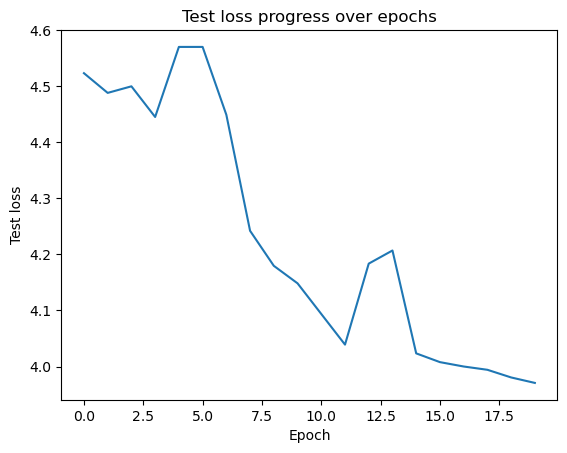

In [8]:
#plot test progress
# Convert tensors to Python numbers
# losses_test_plot = [loss.item() for loss in loss_test]

# Plot as usual
x_axis=[iii for iii in range(1,n_epochs+1,1)]
plt.plot(loss_test, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss progress over epochs')
plt.show()

In [ ]:
#save the model
# Assuming `model` is an instance of the CLIP class
torch.save(model.state_dict(), model_save_dr+str(100*prob)+".pth")